In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
 # Load csv file of bitcoin data
csv_path = Path("BTC2016.csv")
btc=pd.read_csv(csv_path)
btc.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2016-07-28,655.42700,656.91599,658.63100,654.16099
1,BTC,2016-07-29,656.68100,655.42700,658.25299,654.38500
2,BTC,2016-07-30,635.58800,656.68100,658.28300,634.84899
3,BTC,2016-07-31,621.37299,635.58800,639.38199,616.04800
4,BTC,2016-08-01,601.22700,621.37299,627.06800,600.74100


In [3]:
btc = btc.drop(columns="Currency")

In [4]:
btc['Date']=btc['Date'].astype('datetime64[ns]')

In [5]:
# Set the `Date` column as the index
btc = btc.set_index("Date", drop=True)

In [6]:
btc.head()

,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,
2016-07-28,655.42700,656.91599,658.63100,654.16099
2016-07-29,656.68100,655.42700,658.25299,654.38500
2016-07-30,635.58800,656.68100,658.28300,634.84899
2016-07-31,621.37299,635.58800,639.38199,616.04800
2016-08-01,601.22700,621.37299,627.06800,600.74100


In [7]:
# Rename the columns
btc.columns = ['Close', 'Open', 'High', 'Low']
btc.head()

,Close,Open,High,Low
Date,,,,
2016-07-28,655.42700,656.91599,658.63100,654.16099
2016-07-29,656.68100,655.42700,658.25299,654.38500
2016-07-30,635.58800,656.68100,658.28300,634.84899
2016-07-31,621.37299,635.58800,639.38199,616.04800
2016-08-01,601.22700,621.37299,627.06800,600.74100


In [27]:
## Initialize the short and long windows
short_window = 20
long_window = 50

In [28]:
## Initialize the signals DataFrame with the signal column

signals = pd.DataFrame(index=btc.index)
signals['close'] = btc['Close']
signals['signal'] = 0.0

In [29]:
## Create short simple moving average over the short window

signals['SMA20'] = btc['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

In [30]:
## Create long simple moving average over the long window

signals['SMA50'] = btc['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

In [35]:
## Create signals

signals['signal'][short_window:] = np.where(signals['SMA20'][short_window:] > signals['SMA50'][short_window:],1.0,0.0)

In [36]:
## Generate trading orders

signals['entry/exit'] = signals['signal'].diff()

In [37]:
signals.head()

,close,signal,SMA20,SMA50,entry/exit
Date,,,,,
2016-07-28,655.42700,0.0,655.427000,655.427000,NaN
2016-07-29,656.68100,0.0,656.054000,656.054000,0.0
2016-07-30,635.58800,0.0,649.232000,649.232000,0.0
2016-07-31,621.37299,0.0,642.267247,642.267247,0.0
2016-08-01,601.22700,0.0,634.059198,634.059198,0.0


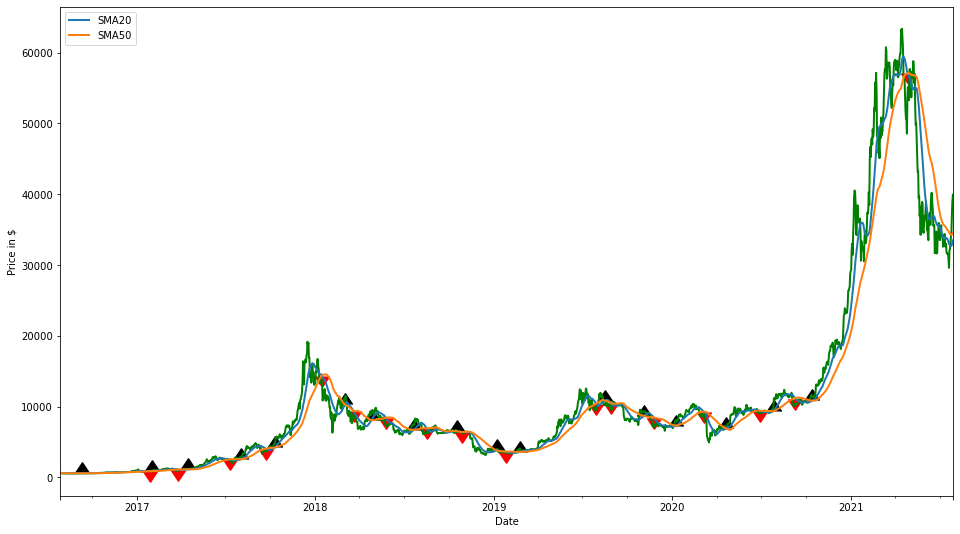

In [47]:
## Initialize the plot figure

fig = plt.figure(figsize=(16,9))

## Add a subplot and label for y-axis

ax1 = fig.add_subplot(111,ylabel='Price in $')

## Plot the closing price

btc['Close'].plot(ax=ax1, color='g', lw=2.)

## Plot the short and long moving averages

signals[['SMA20','SMA50']].plot(ax=ax1, lw=2.)

## Plot the buy signals

#signals.short_mavg[signals.positions == 1.0].scatter(ax=ax1, color='g')
plt.scatter(signals.loc[signals['entry/exit'] == 1.0].index, 
            signals.SMA20[signals['entry/exit'] == 1.0],
            marker=10, s=200, color='black')

## Plot the sell signals
plt.scatter(signals.loc[signals['entry/exit'] == -1.0].index,
            signals.SMA20[signals['entry/exit'] == -1.0],
            marker=11, s=200, color='r')


## Show the plot

plt.show()

### Backtest the Trading Strategy

In [49]:
# Set initial capital
initial_capital = float(100000)

# Set the share size
share_size = 500

# Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
signals['Position'] = share_size * signals['signal']

# Find the points in time where a 500 share position is bought or sold
signals['Entry/Exit Position'] = signals['Position'].diff()

# Multiply share price by entry/exit positions and get the cumulatively sum
signals['Portfolio Holdings'] = signals['close'] * signals['Entry/Exit Position'].cumsum()

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
signals['Portfolio Cash'] = initial_capital - (signals['close'] * signals['Entry/Exit Position']).cumsum()

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
signals['PortfolioTotal'] = signals['Portfolio Cash'] + signals['Portfolio Holdings']

# Calculate the portfolio daily returns
signals['Portfolio Daily Returns'] = signals['PortfolioTotal'].pct_change()

# Calculate the cumulative returns
signals['Portfolio Cumulative Returns'] = (1 + signals['Portfolio Daily Returns']).cumprod() - 1

# Print the DataFrame
signals.tail()

,close,signal,SMA20,SMA50,entry/exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,PortfolioTotal,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,
2021-07-24,34014.618359,0.0,32694.495723,34261.140192,0.0,0.0,0.0,0.0,2.680270e+07,2.680270e+07,0.0,267.026961
2021-07-25,34574.670661,0.0,32718.384542,34253.005991,0.0,0.0,0.0,0.0,2.680270e+07,2.680270e+07,0.0,267.026961
2021-07-26,37114.296624,0.0,32871.721993,34288.578340,0.0,0.0,0.0,0.0,2.680270e+07,2.680270e+07,0.0,267.026961
2021-07-27,38963.922857,0.0,33109.593409,34387.525490,0.0,0.0,0.0,0.0,2.680270e+07,2.680270e+07,0.0,267.026961
2021-07-28,39917.449369,0.0,33476.482483,34515.789345,0.0,0.0,0.0,0.0,2.680270e+07,2.680270e+07,0.0,267.026961


### Plot Entry/Exit Points of Trading Strategy vs. Backtest Results

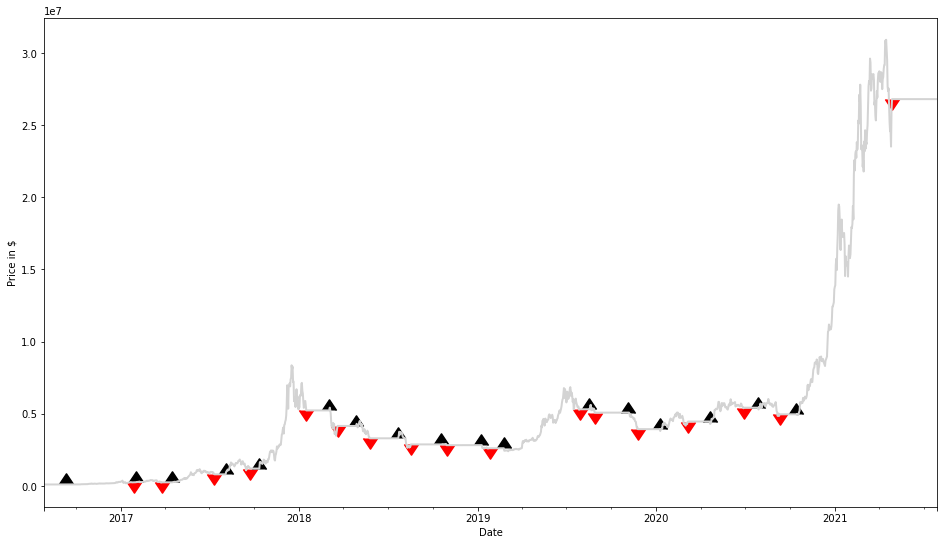

In [48]:
# Visualize exit position relative to total portfolio value
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111,ylabel='Price in $')

## Plot the total portoflio value for the investment
#btc['Close'].plot(ax=ax1, color='g', lw=2.)
signals['PortfolioTotal'].plot(ax=ax1, color='lightgrey', lw=2.)

# Plot exit position relative to total portfolio value
plt.scatter(signals.loc[signals['entry/exit'] == -1.0].index,
            signals.PortfolioTotal[signals['entry/exit'] == -1.0],
            marker=11, s=200, color='r')

# Plot entry position relative to total portfolio value
plt.scatter(signals.loc[signals['entry/exit'] == 1.0].index,
            signals.PortfolioTotal[signals['entry/exit'] == 1.0],
            marker=10, s=200, color='black')

In [42]:
signals[signals['entry/exit'] == 1.0]['PortfolioTotal']

Date
2016-09-11    1.000000e+05
2017-02-01    2.574838e+05
2017-04-16    2.502165e+05
2017-08-03    8.045734e+05
2017-10-11    1.204800e+06
2018-03-03    5.233055e+06
2018-04-26    4.159005e+06
2018-07-22    3.300602e+06
2018-10-18    2.878300e+06
2019-01-07    2.824070e+06
2019-02-23    2.610893e+06
2019-08-17    5.311689e+06
2019-11-05    5.077219e+06
2020-01-08    3.934786e+06
2020-04-19    4.464301e+06
2020-07-27    5.422291e+06
2020-10-13    4.962631e+06
Name: PortfolioTotal, dtype: float64

### portofolio evaluation metrics

In [43]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
portfolio_evaluation_df

,Backtest
Annual Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [44]:
# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns'] = signals['Portfolio Cumulative Returns'][-1]

# Calculate annualized return
portfolio_evaluation_df.loc['Annual Return'] = (
    signals['Portfolio Daily Returns'].mean() * 252
)

# Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility'] = (
    signals['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    signals['Portfolio Daily Returns'].mean() * 252) / (
    signals['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Downside Return
sortino_ratio_df = signals[['Portfolio Daily Returns']].copy()
sortino_ratio_df.loc[:,'Downside Returns'] = 0

target = 0
mask = sortino_ratio_df['Portfolio Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2
portfolio_evaluation_df

# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev

portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
portfolio_evaluation_df.head()

,Backtest
Annual Return,0.981331
Cumulative Returns,267.026961
Annual Volatility,0.647606
Sharpe Ratio,1.51532
Sortino Ratio,2.405321


### Trade Evaluation Metrics

In [45]:
# Initialize trade evaluation DataFrame with columns
trade_evaluation_df = pd.DataFrame(
    columns=[
        'Cryptocurrency', 
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
)

trade_evaluation_df

,Cryptocurrency,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss


In [46]:
# Initialize iterative variables
entry_date = ''
exit_date = ''
entry_portfolio_holding = 0
exit_portfolio_holding = 0
share_size = 0
entry_share_price = 0
exit_share_price = 0

# Loop through signal DataFrame
# If `Entry/Exit` is 1, set entry trade metrics
# Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
# Then append the record to the trade evaluation DataFrame
for index, row in signals.iterrows():
    if row['entry/exit'] == 1:
        entry_date = index
        entry_portfolio_holding = abs(row['Portfolio Holdings'])
        share_size = row['Entry/Exit Position']
        entry_share_price = row['close']

    elif row['entry/exit'] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row['close'] * row['Entry/Exit Position'])
        exit_share_price = row['close']
        profit_loss =  exit_portfolio_holding - entry_portfolio_holding
        trade_evaluation_df = trade_evaluation_df.append(
            {
                'Cryptocurrency': 'BTC',
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Shares': share_size,
                'Entry Share Price': entry_share_price,
                'Exit Share Price': exit_share_price,
                'Entry Portfolio Holding': entry_portfolio_holding,
                'Exit Portfolio Holding': exit_portfolio_holding,
                'Profit/Loss': profit_loss
            },
            ignore_index=True)

# Print the DataFrame
trade_evaluation_df

,Cryptocurrency,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,BTC,2016-09-11,2017-01-27,500.0,604.827500,919.795000,3.024138e+05,4.598975e+05,1.574838e+05
1,BTC,2017-02-01,2017-03-26,500.0,982.827500,968.293000,4.914138e+05,4.841465e+05,-7.267250e+03
2,BTC,2017-04-16,2017-07-11,500.0,1184.200000,2292.913750,5.921000e+05,1.146457e+06,5.543569e+05
3,BTC,2017-08-03,2017-09-22,500.0,2811.710000,3612.162500,1.405855e+06,1.806081e+06,4.002262e+05
4,BTC,2017-10-11,2018-01-15,500.0,4858.604990,12915.116250,2.429302e+06,6.457558e+06,4.028256e+06
5,BTC,2018-03-03,2018-03-21,500.0,11171.817500,9023.717500,5.585909e+06,4.511859e+06,-1.074050e+06
6,BTC,2018-04-26,2018-05-25,500.0,9153.641250,7436.835000,4.576821e+06,3.718418e+06,-8.584031e+05
7,BTC,2018-07-22,2018-08-17,500.0,7411.200525,6566.595283,3.705600e+06,3.283298e+06,-4.223026e+05
8,BTC,2018-10-18,2018-10-29,500.0,6374.648863,6266.189683,3.187324e+06,3.133095e+06,-5.422959e+04
9,BTC,2019-01-07,2019-01-26,500.0,3989.631741,3563.278010,1.994816e+06,1.781639e+06,-2.131769e+05
